In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import os.path
from PIL import Image


In [2]:
def showImage(image):
    tensor_normalized = (image - image.min()) / (image.max() - image.min())
    plt.imshow(tensor_normalized)
    plt.axis('off')  # Turn off axis labels
    plt.show()

In [3]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

cuda


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(
    #     (0.5, 0.5, 0.5),
    #     (0.5, 0.5, 0.5)
    # )
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(train_loader.dataset[0])


(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0

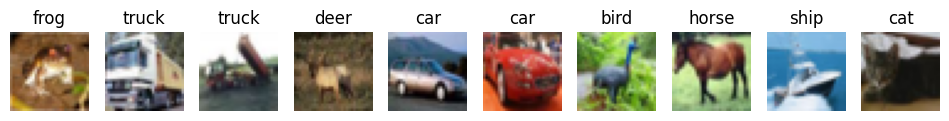

In [5]:
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    image = train_loader.dataset[i][0].permute(1, 2, 0)
    # denormalized_image= image / 2 + 0.5
    axes[i].imshow(image)
    axes[i].set_title(classes[train_loader.dataset[i][1]])
    axes[i].axis('off')
plt.show()


In [8]:
class ConvNeuralNet(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)

        self.pool = nn.MaxPool2d(2, stride=2)

        self.gap = nn.AdaptiveAvgPool2d(1) # to work with variable image sizes

        # self.fc1 = nn.Linear(128 * 6 * 6, 120)
        self.fc1 = nn.Linear(128, 120) # because output of self.gap is [batch, 128, 1, 1]
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.gap(x) # to work with variable image sizes
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = F.softmax(self.fc3(x), dim=1)
        # print(x)
        return x

net = ConvNeuralNet()
net.to(device)
PATH = './cifar_net_variable_image_sizes.pth'

In [9]:
if os.path.isfile(PATH):
    net.load_state_dict(torch.load(PATH, weights_only=True))
    print("existing model loaded")
    
    # for i, data in enumerate(train_loader):
    #     inputs, labels = data[0].to(device), data[1].to(device)
    #     print(inputs.shape)
else:
    print("no existing model found. Initiating training\n")
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    epochs = 10
    for epoch in range(epochs):
    
        running_loss = 0.0
        for i, data in enumerate(train_loader):
    
            inputs, labels = data[0].to(device), data[1].to(device)
    
            optimizer.zero_grad()
            outputs = net(inputs)
            
            if i == 0:
                print(labels)
                print(outputs)
            
            loss = loss_function(outputs, labels)
    
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f'[{epoch + 1}/{epochs}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
    
    print('Finished Training')
    torch.save(net.state_dict(), PATH)

no existing model found. Initiating training

tensor([6, 4, 9, 3], device='cuda:0')
tensor([[ 0.0891, -0.0822, -0.0969,  0.0984, -0.0343, -0.0154, -0.0136, -0.0300,
          0.0313, -0.0239],
        [ 0.0864, -0.0838, -0.0993,  0.0957, -0.0342, -0.0145, -0.0125, -0.0322,
          0.0293, -0.0252],
        [ 0.0858, -0.0845, -0.0981,  0.0948, -0.0333, -0.0150, -0.0125, -0.0312,
          0.0289, -0.0228],
        [ 0.0863, -0.0838, -0.0991,  0.0951, -0.0338, -0.0152, -0.0128, -0.0314,
          0.0290, -0.0239]], device='cuda:0', grad_fn=<AddmmBackward0>)
[1/10,  2000] loss: 2.022
[1/10,  4000] loss: 1.822
[1/10,  6000] loss: 1.724
[1/10,  8000] loss: 1.686
[1/10, 10000] loss: 1.646
[1/10, 12000] loss: 1.586
tensor([9, 7, 5, 7], device='cuda:0')
tensor([[ 2.5969, -0.9035, -0.9982, -2.4636, -2.7575, -3.3049, -4.6136, -5.4145,
          2.5881, -0.4049],
        [-1.5635, -1.1474, -0.8696, -0.0976, -0.3050,  0.0058, -1.8594,  2.3930,
         -3.8227,  0.4785],
        [-2.6945, -2.801

In [10]:
def view_classification(image, probabilities):
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)

    image = image.permute(1, 2, 0)
    # denormalized_image= image / 2 + 0.5
    ax1.imshow(image)
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()

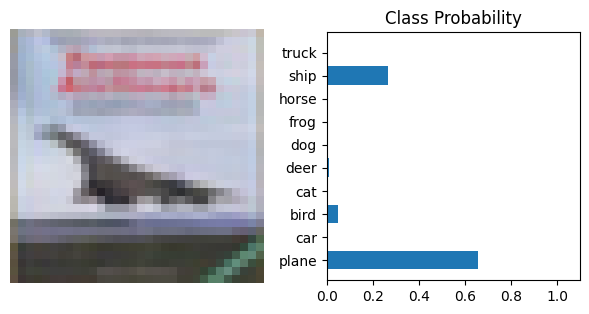

In [11]:
images, _ = next(iter(test_loader))

image = images[3]
batched_image = image.unsqueeze(0).to(device)
with torch.no_grad():
    log_probabilities = net(batched_image)
    probabilities = torch.softmax(log_probabilities, dim=1)

probabilities = probabilities.squeeze().cpu()
view_classification(image, probabilities)

In [12]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # print(labels)

        outputs = net(images)
        # print(outputs)

        _, predicted = torch.max(outputs.data, 1)
        # print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print(correct)
        # print()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [13]:
# Freeze all the parameters in the network
net.eval()
for param in net.parameters():
    param.requires_grad = False

torch.Size([3, 1500, 2100])


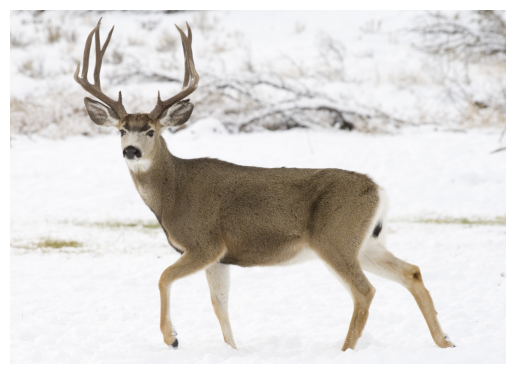

In [48]:
'''
With a higher res image
'''

pilimage = Image.open('deer.jpg')
tensorpilimage = transform(pilimage)
print(tensorpilimage.shape)
showImage(tensorpilimage.permute(1, 2, 0))

In [80]:
original_img = test_loader.dataset[1][0]
# original_img = tensorpilimage
original_img = original_img.to(device)

img = original_img.to(device)
img = img.unsqueeze(0)
img = img.requires_grad_(True)

label = torch.tensor([5]).to(device)

# input_img = torch.stack(iterable_of_tensors)
# print(iterable_of_tensors)

# print(f"model parameter values before gradient descent propagation\n")
# for idx, param in enumerate(iterable_of_tensors):
#     print(f"{param.data}\n")

# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()
loss_function2 = nn.L1Loss()

optim = torch.optim.SGD([img], lr=0.001, momentum=0.7)

predictedClass = -1

# for _ in range(150):
while predictedClass != label.item():
    
    optim.zero_grad()
    
    output = net(img)

    # probabilities = torch.softmax(output, dim=1).squeeze().cpu()
    # print(classes[torch.argmax(probabilities).item()])
    # print(output)
    # print(label)

    probabilities = torch.softmax(output, dim=1)
    predictionTensor = torch.argmax(probabilities)
    predictionInt = predictionTensor.item()
    predictedClass = predictionInt
    print(classes[predictionInt])

    celoss = loss_function(output, label)
    l1loss = loss_function2(original_img, img)
    loss = celoss + l1loss
    
    loss.backward()
    optim.step()

    # print(iterable_of_tensors)

# print()
# print()
# print()
# print(iterable_of_tensors)
    # with torch.no_grad():
    #     log_probabilities = net()
    
    # probabilities = torch.exp(log_probabilities).squeeze().cpu()

# print(f"model parameter values after gradient descent propagation\n")
# for idx, param in enumerate(iterable_of_tensors):
#     print(f"{param.data}\n")

ship
ship
ship
ship
ship
ship
ship
ship
ship
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bir

/home/jv/school/schakeliiw/bachelorproef/venv-bachelorproject/lib/python3.12/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([1, 3, 32, 32])) that is different to the input size (torch.Size([3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


bird
bird
bird
bird
bird
bird
bird
bird
bird
dog


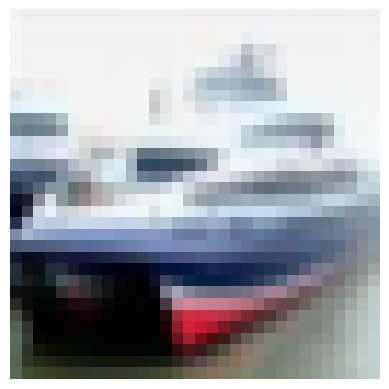

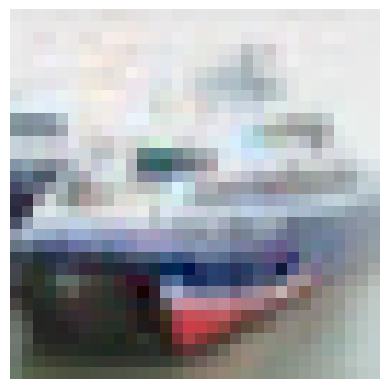

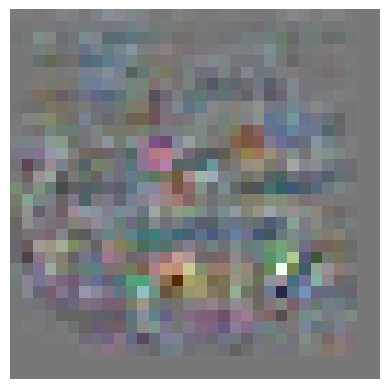

deer


In [83]:
'''
reverse iterable tensors
'''

image = test_loader.dataset[1][0]
# image = tensorpilimage
# denormalized_image= image / 2 + 0.5

showImage(image.permute(1, 2, 0))
showImage(img.squeeze().detach().permute(1, 2, 0).cpu())

diff = image - img.squeeze().detach().cpu()

showImage(diff.permute(1, 2, 0))

new_img = test_loader.dataset[126][0]
new_img += diff

output = net(new_img.to(device).unsqueeze(0))

probabilities = torch.softmax(output, dim=1)
predictionTensor = torch.argmax(probabilities)
predictionInt = predictionTensor.item()
predictedClass = predictionInt
print(classes[predictionInt])

# reconstructed_img = torch.stack(iterable_of_tensors, dim = 0)

# mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(3, 1, 1)
# std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(3, 1, 1)
# reconstructed_img2 = reconstructed_img / 2 + 0.5  # Reverse normalization
# output = net(reconstructed_img.unsqueeze(0))
# print(reconstructed_img)


# Clip to valid range [0, 1] (for visualization)
# reconstructed_img2 = torch.clamp(reconstructed_img2, 0, 1)

# probabilities = torch.softmax(output, dim=1).squeeze().cpu()
# print(probabilities.sum())
# print(classes[torch.argmax(probabilities).item()])

# # Convert to NumPy and permute dimensions for matplotlib (H × W × C)
# img_np = reconstructed_img2.detach().cpu().numpy().transpose(1, 2, 0)

# # Visualize
# plt.imshow(img)
# plt.axis('off')  # Hide axes
# plt.show()

# # Visualize
# plt.imshow(img_np)
# plt.axis('off')  # Hide axes
# plt.show()